# Training

Nick Sciarrilli <br>
Comp 4449 <br>
Midterm <br>
02.02.2022

In [1]:
#!pip3 install -U torch torchvision
!pip3 install pycocotools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import os
import json
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import pil_loader

In [3]:
torch.__version__

torch.manual_seed(0)

In [4]:
mapping = {
    'pedestrian': 0,
    'rider': 1,
    'car': 2,
    'truck': 3,
    'bus': 4,
    'train': 5,
    'motorcycle': 6,
    'bicycle': 7,
    'traffic light': 8,
    'traffic sign':9
}

In [5]:
# root = 'data/bdd100k'

# label_paths = glob.glob(
#     os.path.join(root, 'labels/train/*.json'))
# image_dir = os.path.join(root, 'images/100k/train')

# samples = []
# for label_path in label_paths:
#     image_path = os.path.join(
#         image_dir,
#         os.path.basename(label_path).replace('.json', '.jpg'))
#     if os.path.exists(image_path):
#         samples.append((image_path, label_path))

# index = 0
# image_path, label_path = samples[index]

# image = pil_loader(image_path)
# label = load_json(label_path)

In [6]:
# samples[0]

In [7]:
# label_path

In [8]:
# label['labels'][0]['category']

In [9]:
# labels = df.labels.iloc[0]

In [10]:
# target = {}
# target['boxes'] = []
# for label in labels:
#     if label['category'] in mapping:
#         print(label)
#         target['label'] = mapping[label['category']]
#         target['boxes'].append(label['box2d'])

# print()
# print(target)

In [11]:
# row = df.labels.iloc[0]

# labels = []
# boxes = []
# for label in row:
#     if label['category'] in mapping:
#         #print(label)
#         x1 = label['box2d']['x1']
#         x2 = label['box2d']['x2']
#         y1 = label['box2d']['y1']
#         y2 = label['box2d']['y2']
#         boxes.append(np.array([x1, y1, x2, y2]))
#         labels.append(mapping[label['category']])

# target = {}
# target['boxes'] = torch.tensor(boxes, dtype=torch.float)
# target['labels'] = torch.tensor(labels, dtype=torch.int64)
# #print()
# print(target)

In [12]:
def load_json(f):
    with open(f, 'r') as fp:
        return json.load(fp)


def save_json(obj, f, *args, **kwargs):
    with open(f, 'w') as fp:
        json.dump(obj, fp, *args, **kwargs)


class BDDDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.samples = None
        self.prepare()

    def prepare(self):
        self.samples = []

        label_paths = glob.glob(
            os.path.join(self.root, 'labels/train/*.json'))[:10000]
        image_dir = os.path.join(self.root, 'images/100k/train')

        for label_path in label_paths:
            image_path = os.path.join(
                image_dir,
                os.path.basename(label_path).replace('.json', '.jpg'))
            if os.path.exists(image_path):
                self.samples.append((image_path, label_path))

    def __getitem__(self, index):
        # TODO: handle label dict
        image_path, label_path = self.samples[index]
        #image = pil_loader(image_path)
        img = Image.open(image_path).convert("RGB")
        json_labels = load_json(label_path)

        mapping = {
            'pedestrian': 0,
            'rider': 1,
            'car': 2,
            'truck': 3,
            'bus': 4,
            'train': 5,
            'motorcycle': 6,
            'bicycle': 7,
            'traffic light': 8,
            'traffic sign':9
        }
        
        labels = []
        boxes = []
        for label in json_labels['labels']:
            if label['category'] in mapping:
                #print(label)
                x1 = label['box2d']['x1']
                #print(f'x1 {type(x1)}')
                x2 = label['box2d']['x2']
                y1 = label['box2d']['y1']
                y2 = label['box2d']['y2']
                boxes.append([x1, y1, x2, y2])
                labels.append(mapping[label['category']])
                
        #
        #
        #
        # changed boxes from float32 to 16
        #
        #
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id = torch.tensor([index])
        
        try: 
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        except:
            print(boxes)
            print(image_path)
            pass
            
        num_objs = len(boxes)
        
        #
        #
        #
        #
        # changed iscrowd from int64 to 32
        #
        #
        #
        #
        #
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.LongTensor(labels)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.samples)

In [13]:
# import transforms as T

# def get_transform(train):
#     transforms = []
#     transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

# drive_dataset = BDDDataset('data/bdd100k', get_transform(train=True))

In [14]:
# len(drive_dataset)

In [15]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

In [16]:
# torch.manual_seed(0)

# train_set, test_set = torch.utils.data.random_split(drive_dataset, [7000, 3000])

In [17]:
# train_loader = DataLoader(train_set, batch_size=8, num_workers=4, collate_fn=collate_fn)
# #val_loader = DataLoader(val_set, batch_size=8, num_workers=4, collate_fn=collate_fn)
# test_loader = DataLoader(test_set, batch_size=8, num_workers=4, collate_fn=collate_fn)

In [18]:
#train_set.dataset.__getitem__(0)

In [19]:
# it = iter(train_loader)

In [20]:
# first = next(it)

In [21]:
#first

In [22]:
#first[0][0]

In [23]:
# img = transforms.ToPILImage()(first[0][0].squeeze_(0))
# img.size

In [24]:
# boxes = first[1][0]['boxes']

In [25]:
#boxes

In [26]:
# for i in boxes:
#     print(i)

In [27]:
# plt.figure(figsize=(12,7))
# plt.imshow(img);
# #plt.show()

In [28]:
# colors = ['C'+str(i) for i in range(10)]

# fig, ax = plt.subplots(figsize = (21,14))
# ax.imshow(img)

# idx = 0
# for box in boxes:
#     #print(box)
#     idx += 1
#     try:
#         x1 = box[0]
#         x2 = box[2]
#         y1 = box[1]
#         y2 = box[3]

#         #print(x1, y1, x2, y2)

#         x = x1
#         y = y2
#         w = x2 - x1
#         h = y1 - y2

#         plt.plot(x1, y1, marker='o', color="white")
#         plt.plot(x2, y2, marker='o', color="white")
#         color = np.random.choice(colors)
#         ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

#         cat = i['category']
#         ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
#     except:
#         continue

# 1. Finetuning from a pretrained model

In [29]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# # load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# num_classes = 11  # len(mapping)

# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



# ### added function

# def get_model_finetuning(num_classes):
#     # load a model pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#     # num_classes = 11  # len(mapping)

#     # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
#     return model

# 2. Modify the model to add a difference backbone

In [30]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=11,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


# function to get diff backbone model

def get_model_diff_backbone(num_classes):
    
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    
    return model

In [31]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Test *forward()* methhod - test to make sure we are ready to rock n roll

In [32]:
# import utils

# #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = get_model_diff_backbone(11)

# dataset = BDDDataset('data/bdd100k', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn=utils.collate_fn)
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

# Train and validate function

In [33]:
import torch.nn as nn
from engine import train_one_epoch, evaluate
import utils
import sys

def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 11
    # use our dataset and defined transformations
    dataset = BDDDataset('data/bdd100k', get_transform(train=True))
    dataset_test = BDDDataset('data/bdd100k', get_transform(train=False))

    #print(torch.cuda.memory_summary(device=None, abbreviated=False))
    
    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-3000])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-3000:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)
    
#     print(f'sys size of data_loader: {sys.getsizeof(data_loader)}')
#     print('dataloader train')
#     print(torch.cuda.memory_summary(device=None, abbreviated=False))

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=8, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
    
#     print('dataloader test')
#     print(torch.cuda.memory_summary(device=None, abbreviated=False))

    # get the model using our helper function
    #model = get_model_finetuning(num_classes)
    model = get_model_diff_backbone(num_classes)
    
    #print(f'sys size of model: {sys.getsizeof(model)}')
    
#     print('define model')
#     print(torch.cuda.memory_summary(device=None, abbreviated=False))
    
    # data parallel
#     if torch.cuda.device_count() > 1:
#       print("Let's use", torch.cuda.device_count(), "GPUs!")
#       model = nn.DataParallel(model)

    # move model to the right device
    model.to(device)
    
    print('model.to(device)')
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 1 epoch
    num_epochs = 1

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [34]:
main()

model.to(device)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 

/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/875]  eta: 0:16:17  lr: 0.000001  loss: 3.2253 (3.2253)  loss_classifier: 2.3879 (2.3879)  loss_box_reg: 0.0482 (0.0482)  loss_objectness: 0.6981 (0.6981)  loss_rpn_box_reg: 0.0910 (0.0910)  time: 1.1168  data: 0.5265  max mem: 0
Epoch: [0]  [ 10/875]  eta: 0:08:30  lr: 0.000007  loss: 3.2253 (3.2333)  loss_classifier: 2.3824 (2.3752)  loss_box_reg: 0.0468 (0.0436)  loss_objectness: 0.6988 (0.6989)  loss_rpn_box_reg: 0.1093 (0.1157)  time: 0.5905  data: 0.0657  max mem: 0
Epoch: [0]  [ 20/875]  eta: 0:08:03  lr: 0.000013  loss: 3.1882 (3.1830)  loss_classifier: 2.3392 (2.3257)  loss_box_reg: 0.0477 (0.0458)  loss_objectness: 0.6984 (0.6980)  loss_rpn_box_reg: 0.1093 (0.1135)  time: 0.5383  data: 0.0189  max mem: 0
Epoch: [0]  [ 30/875]  eta: 0:07:50  lr: 0.000018  loss: 3.0398 (3.0853)  loss_classifier: 2.1610 (2.2320)  loss_box_reg: 0.0477 (0.0439)  loss_objectness: 0.6946 (0.6964)  loss_rpn_box_reg: 0.1107 (0.1130)  time: 0.5388  data: 0.0183  max mem: 0
Epoch: [0]  

In [ ]:
#
#
#
#
# run all above from here
#
#
#
#
#

In [ ]:
# # flush cache of gpu memory
torch.cuda.empty_cache()

# # show gpu memory utilization
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch.nn as nn

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

In [ ]:
# # flush cache of gpu memory
# torch.cuda.empty_cache()

# # show gpu memory utilization
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
#main()

In [35]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset = BDDDataset('data/bdd100k', get_transform(train=True))
dataset_test = BDDDataset('data/bdd100k', get_transform(train=False))

#print(torch.cuda.memory_summary(device=None, abbreviated=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-3000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-3000:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

#     print(f'sys size of data_loader: {sys.getsizeof(data_loader)}')
#     print('dataloader train')
#     print(torch.cuda.memory_summary(device=None, abbreviated=False))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


num_classes = 11
model = get_model_diff_backbone(num_classes)
model.to(device)

# pick one image from the test set
img, _ = next(iter(data_loader_test))
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    preds = model([img[0].to(device)])


In [36]:
#preds

In [37]:
#img[1]

In [38]:
len(img)

8

In [39]:
len(preds)

1

In [40]:
#preds[0]

In [41]:
img[0].shape

torch.Size([3, 720, 1280])

In [42]:
img_sample = transforms.ToPILImage()(img[1].squeeze_(0))
img_sample.size

NameError: name 'transforms' is not defined

In [43]:
# preds[0]['boxes']

In [44]:
#boxes = prediction[0]['boxes']

In [45]:
float(boxes[0][0])

NameError: name 'boxes' is not defined

In [46]:
boxes[0]

NameError: name 'boxes' is not defined

In [47]:
#colors

In [48]:
mapping

{'pedestrian': 0,
 'rider': 1,
 'car': 2,
 'truck': 3,
 'bus': 4,
 'train': 5,
 'motorcycle': 6,
 'bicycle': 7,
 'traffic light': 8,
 'traffic sign': 9}

In [49]:
reverse_mapping = {v: k for k, v in mapping.items()}
reverse_mapping

{0: 'pedestrian',
 1: 'rider',
 2: 'car',
 3: 'truck',
 4: 'bus',
 5: 'train',
 6: 'motorcycle',
 7: 'bicycle',
 8: 'traffic light',
 9: 'traffic sign'}

In [50]:
# for i in prediction[0]['labels']:
#     print(reverse_mapping[int(i)])

In [51]:
#reverse_mapping[2]

In [52]:
#preds[0]

In [53]:
from torchvision import transforms

def show_img_from_pred(loader):
    #images, _ = next(iter(loader))
    idx = np.random.randint(len(loader.dataset))
    #print(idx)
    image, target = loader.dataset.__getitem__(idx)
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        preds = model([image.to(device)])

    image = transforms.ToPILImage()(image.squeeze_(0))
    fig, ax = plt.subplots(figsize = (21,14))
    ax.imshow(image)
    i = 0
    
    boxes = preds[0]['boxes']
    labels = preds[0]['labels']
    
    for box, lab in zip(boxes, labels):
        #print(lab)
        cat = reverse_mapping[int(lab)]
        #print(box, cat)
        i += 1
        try:
            x1 = float(box[0])
            x2 = float(box[2])
            y1 = float(box[1])
            y2 = float(box[3])

            #print(x1, y1, x2, y2)
            x = x1
            y = y2
            w = x2 - x1
            h = y1 - y2
            
            plt.plot(x1, y1, marker='o', color="white")
            plt.plot(x2, y2, marker='o', color="white")
            
            colors = ['C'+str(i) for i in range(10)]
            color = np.random.choice(colors)
            #print(color)
            ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

            #print(int(lab))
            cat = reverse_mapping[int(lab)]
            #print(cat)
            ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
            #print(idx)
            plt.title(f'Predictions on Image Index: {idx}')
        except:
            continue
    #plt.show()
    return idx

2993

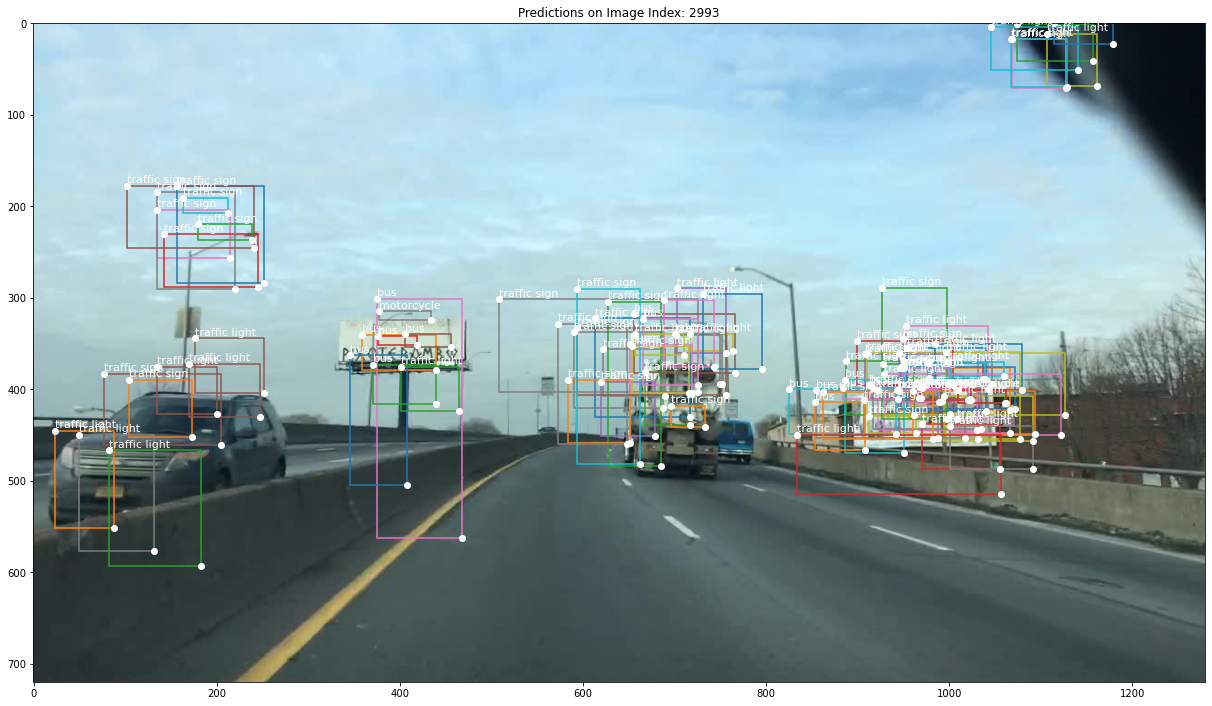

In [54]:
show_img_from_pred(data_loader_test)
#show_img_from_pred(val_loader)

In [55]:
from torchvision import transforms

def show_gt(loader, idx):
    #images, _ = next(iter(loader))
    #idx = np.random.randint(3000)
    image, target = loader.dataset.__getitem__(idx)
    # put the model in evaluation mode
#     model.eval()
#     with torch.no_grad():
#         preds = model([image.to(device)])

    image = transforms.ToPILImage()(image.squeeze_(0))
    fig, ax = plt.subplots(figsize = (21,14))
    ax.imshow(image)
    idx = 0
    
    boxes = target['boxes']
    labels = target['labels']
    
    for box, lab in zip(boxes, labels):
        #print(lab)
        cat = reverse_mapping[int(lab)]
        #print(box, cat)
        idx += 1
        try:
            x1 = float(box[0])
            x2 = float(box[2])
            y1 = float(box[1])
            y2 = float(box[3])

            #print(x1, y1, x2, y2)
            x = x1
            y = y2
            w = x2 - x1
            h = y1 - y2
            
            plt.plot(x1, y1, marker='o', color="white")
            plt.plot(x2, y2, marker='o', color="white")
            
            colors = ['C'+str(i) for i in range(10)]
            color = np.random.choice(colors)
            #print(color)
            ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

            #print(int(lab))
            cat = reverse_mapping[int(lab)]
            #print(cat)
            ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
            plt.title(f'Ground Truth on Image Index: {idx}')
        except:
            continue
    #return plt.show()

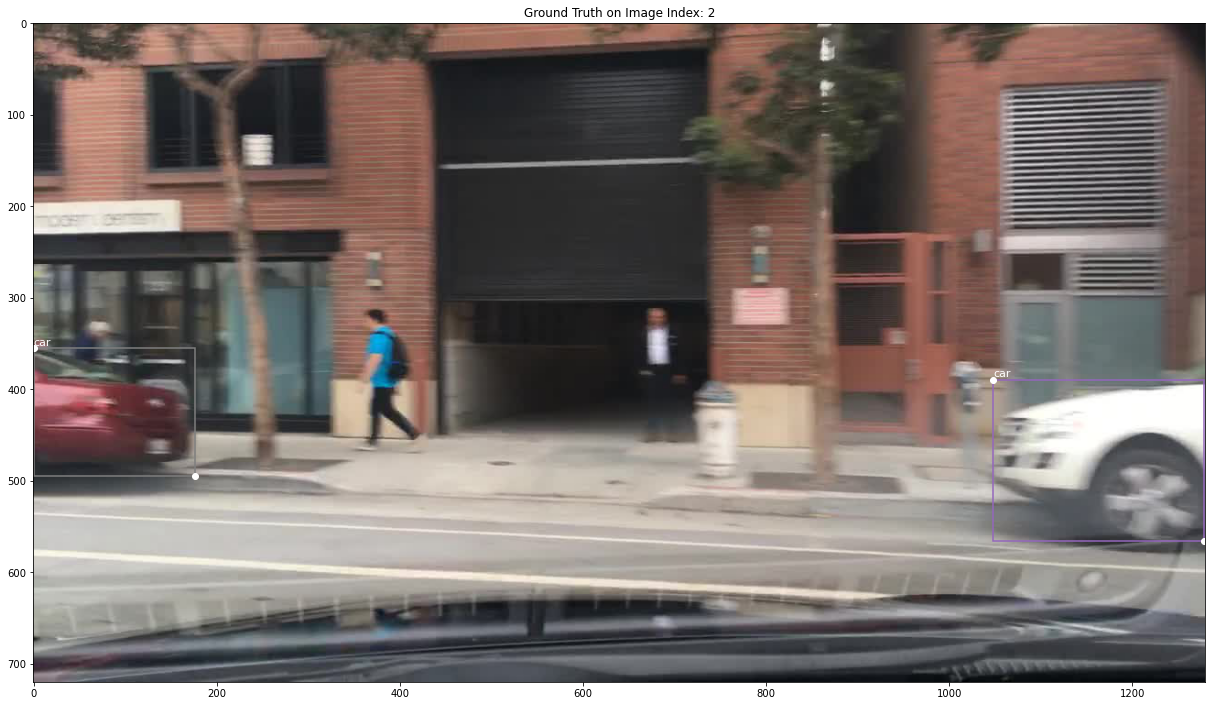

In [56]:
show_gt(data_loader_test, 1470)
#image, target = data_loader_test.dataset.__getitem__(100)

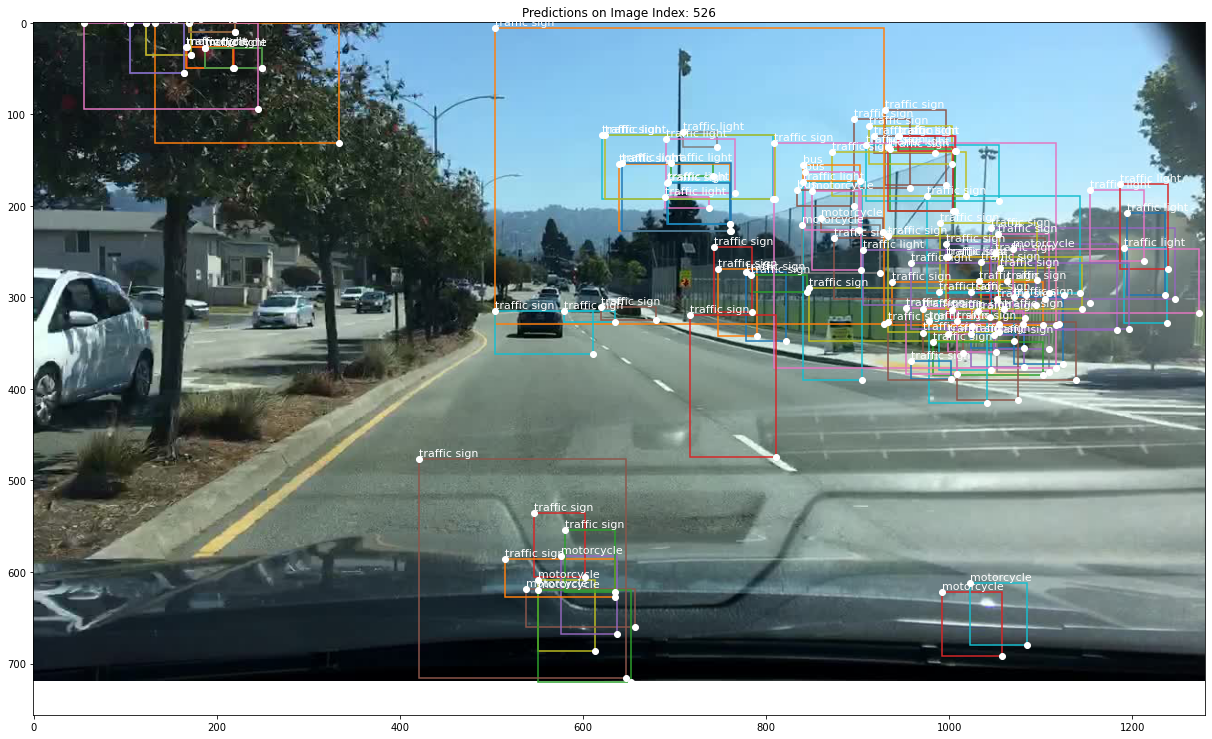

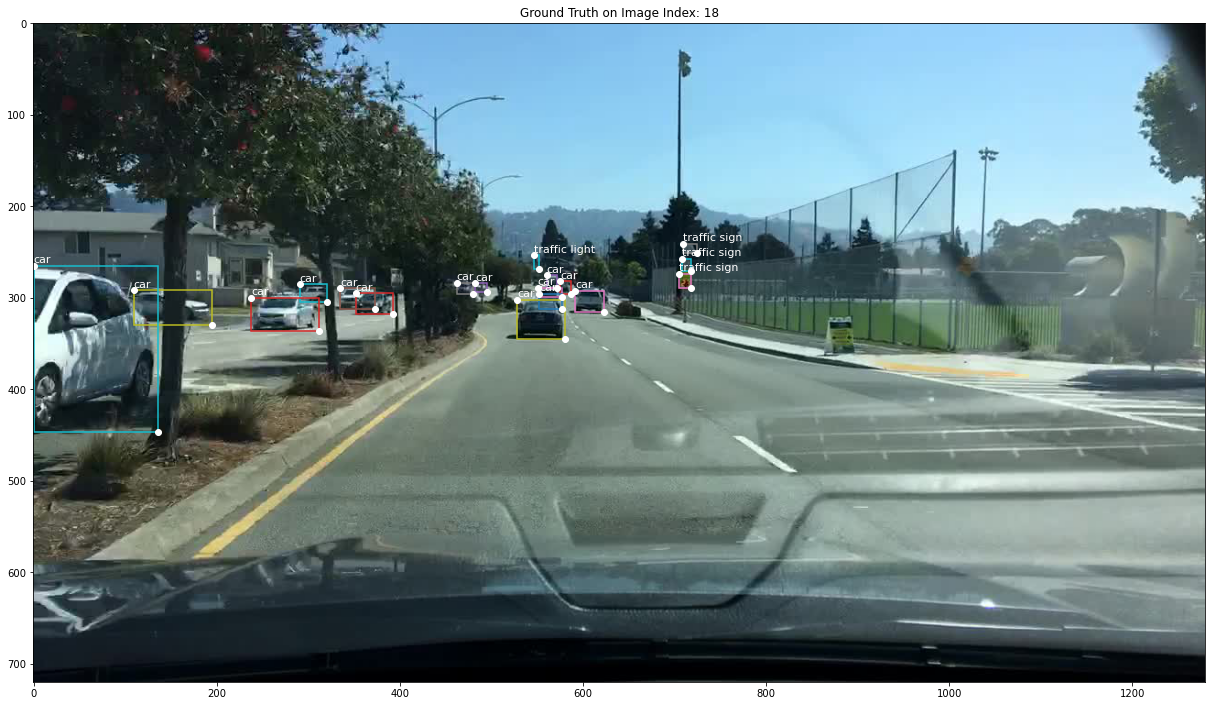

In [57]:
def compare_pred_vs_gt(loader):
    idx = show_img_from_pred(data_loader_test)
    show_gt(data_loader_test, idx)
    #plt.show()
    

compare_pred_vs_gt(data_loader_test)

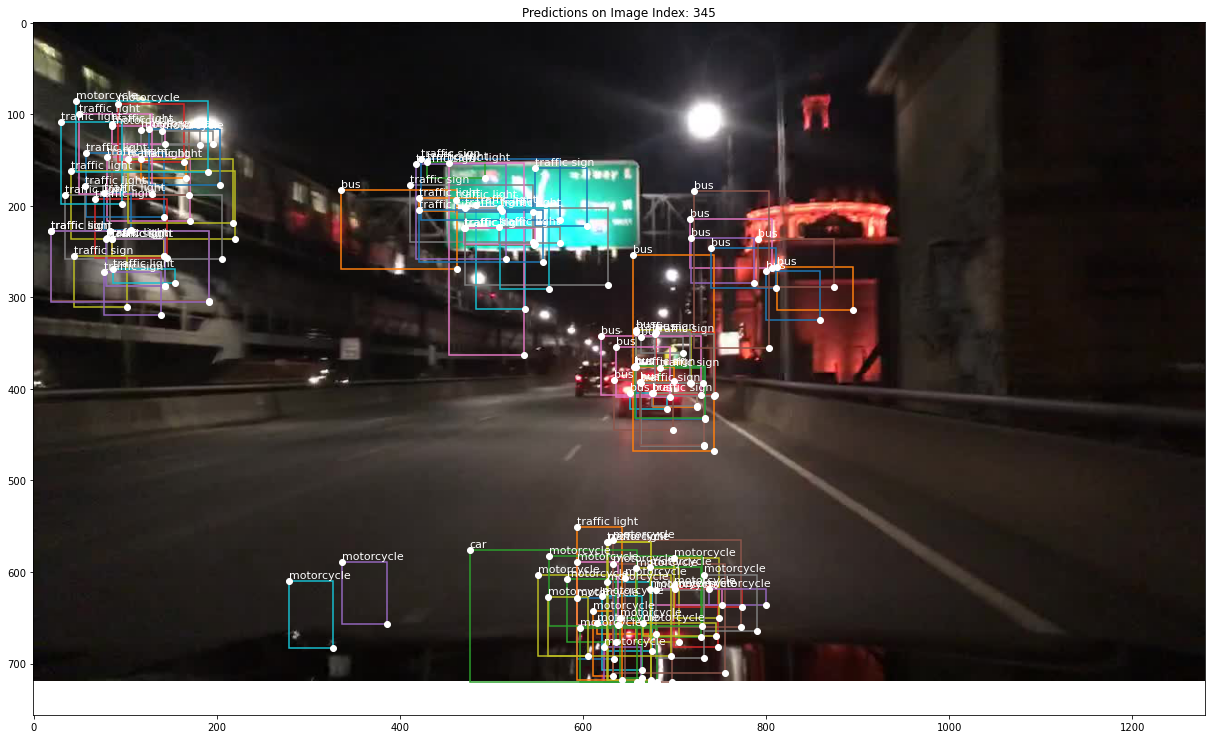

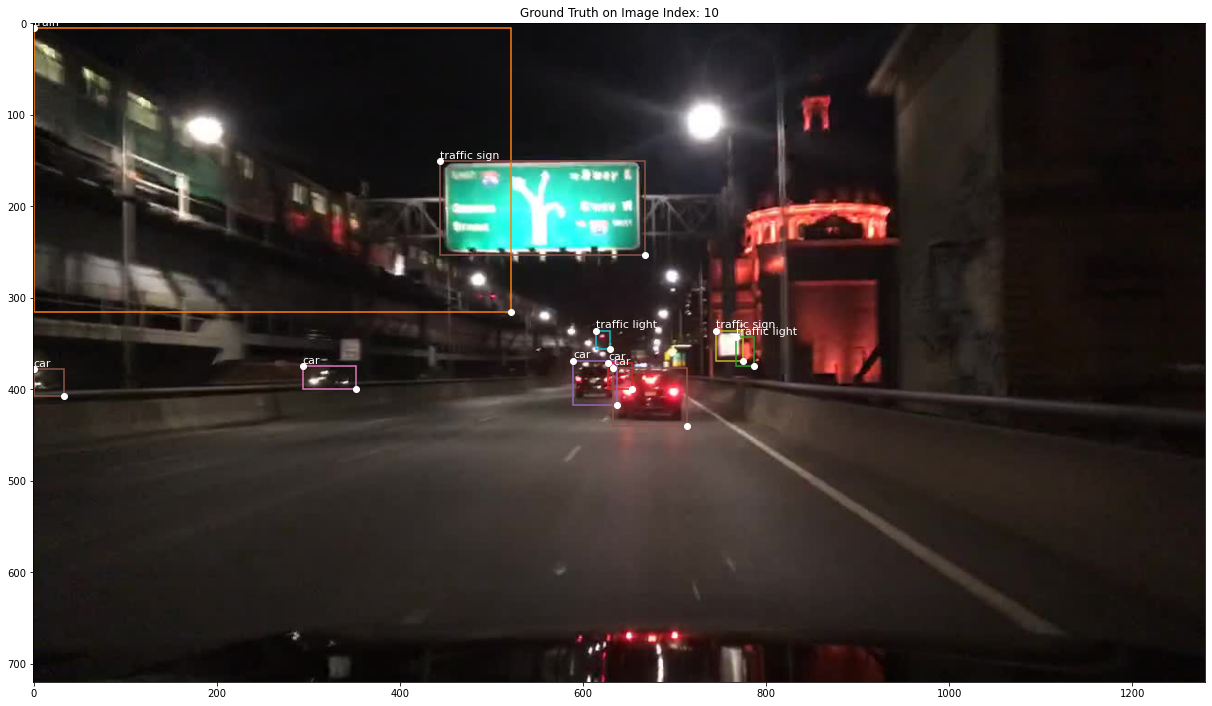

In [58]:
compare_pred_vs_gt(data_loader_test)

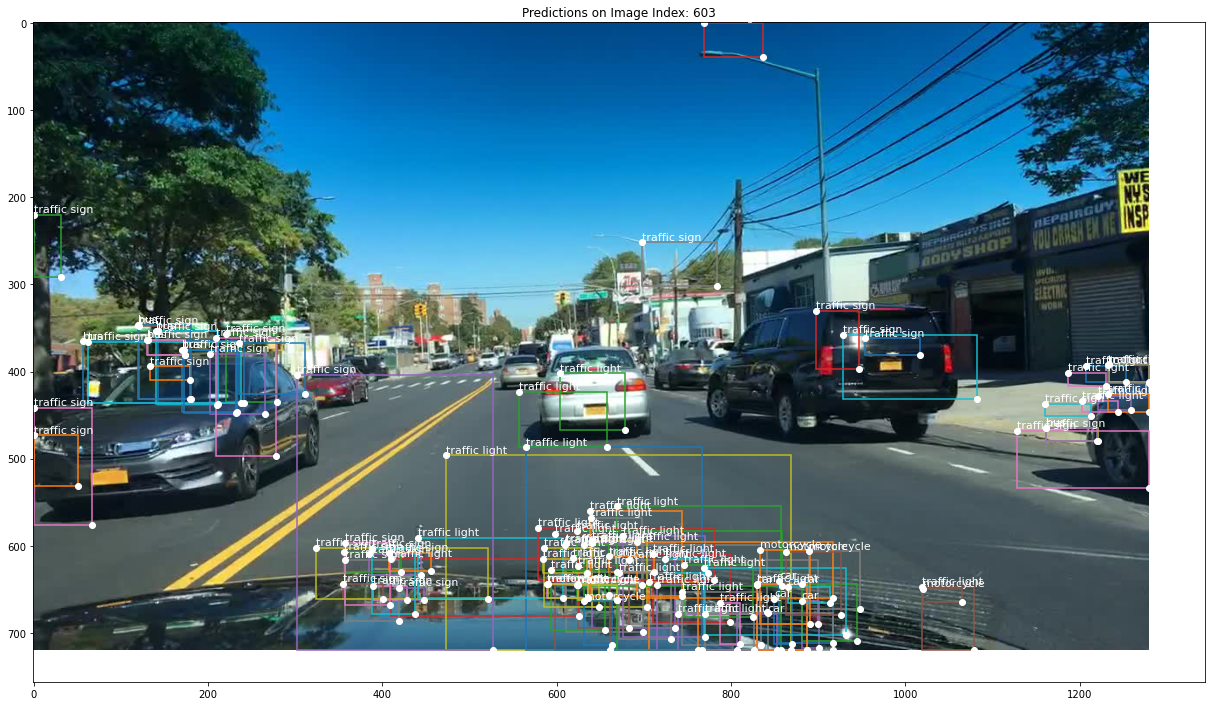

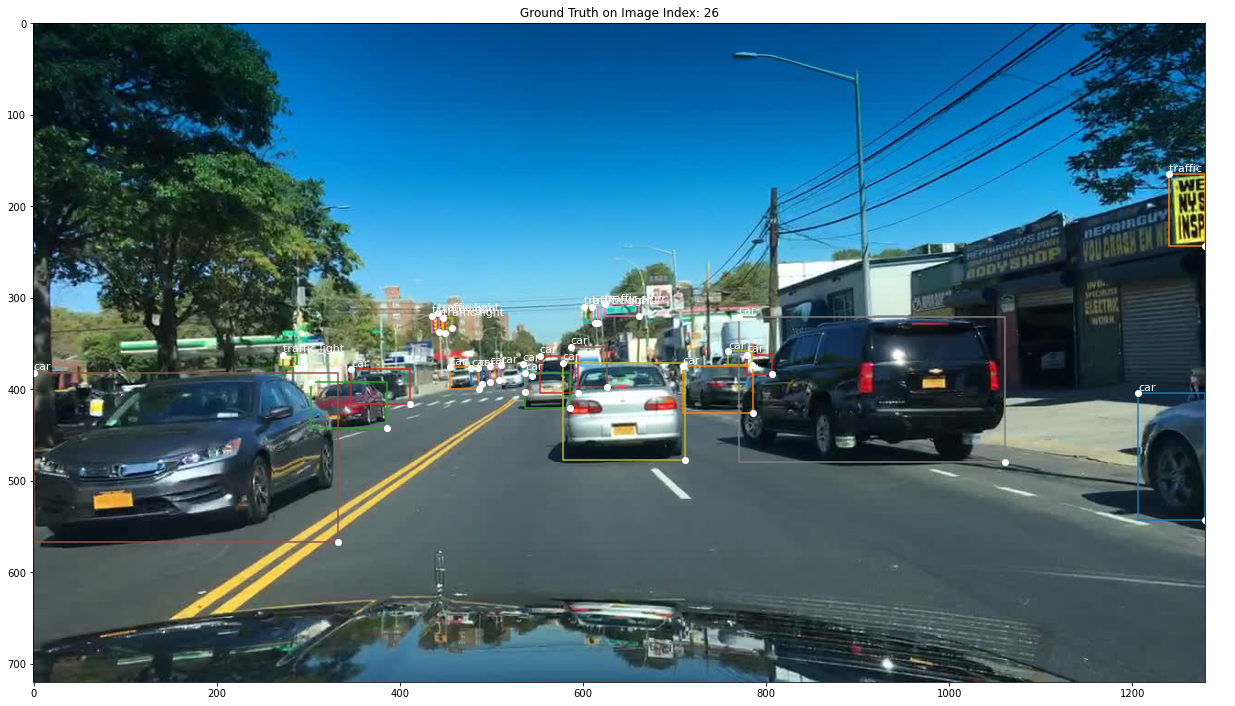

In [59]:
compare_pred_vs_gt(data_loader_test)

KeyError: 10

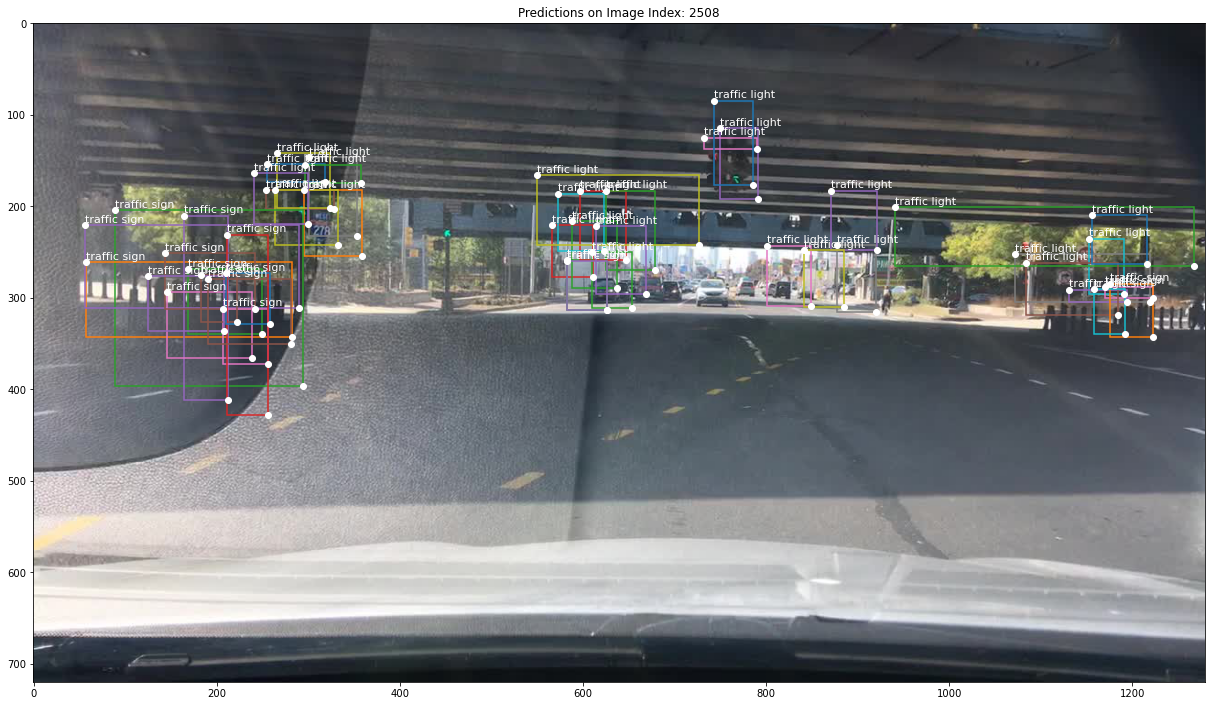

In [62]:
compare_pred_vs_gt(data_loader_test)

In [ ]:
#data_loader_test.dataset.__getitem__(0)

# len(data_loader_test.dataset)

In [ ]:
# idx = np.random.randint(3000)
#data_loader_test.dataset.__getitem__(idx)

# Appendix

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 10

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
import utils
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.to(device)
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [ ]:
from engine import evaluate

from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)
    



In [ ]:
# 1241429282

In [ ]:
#
# searching for labels without bounding boxes which is throwing an error
#


# # use our dataset and defined transformations
# dataset = BDDDataset('data/bdd100k', get_transform(train=True))
# dataset_test = BDDDataset('data/bdd100k', get_transform(train=False))

# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-3000])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-3000:])

# # define training and validation data loaders
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=8, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn)
    
    
# no_boxes = []

# for image, labels in data_loader:
#     if not len(labels[0]['boxes']):
#         no_boxes.append(fname)
#         print(fname)
    

In [ ]:
#
# searching for labels with area which is throwing an error
#

# IndexError: Caught IndexError in DataLoader worker process 3.
# Original Traceback (most recent call last):
#   File "/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
#     data = fetcher.fetch(index)
#   File "/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
#     data = [self.dataset[idx] for idx in possibly_batched_index]
#   File "/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
#     data = [self.dataset[idx] for idx in possibly_batched_index]
#   File "/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 363, in __getitem__
#     return self.dataset[self.indices[idx]]
#   File "/tmp/ipykernel_36111/1241429282.py", line 73, in __getitem__
#     area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
# IndexError: too many indices for tensor of dimension 1


# use our dataset and defined transformations
dataset = BDDDataset('data/bdd100k', get_transform(train=True))
dataset_test = BDDDataset('data/bdd100k', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-3000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-3000:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, num_workers=1,
    collate_fn=utils.collate_fn)
    
    
no_area = []
area = 0
image_ids = []

count = 0
for image, labels in data_loader:
    #print(len(labels))
    #print(labels[0])
    
    for label in labels:
        
        try:
            #print('try')
            area += 1
            #print(type(label['image_id']))
            image_ids.append(int(label['image_id']))
        except:
            print('except')
            print(label['image_id'])
            no_area.append(int(label['image_id']))
            continue
            
#     if count > 1:
#         break
#     count += 1
    
#     if not len(labels[0]['boxes']):
#         no_boxes.append(fname)
#         print(fname)
    

In [ ]:
#area

In [ ]:
no_area

In [ ]:
len(image_ids)

In [ ]:
image_ids[-1]

In [ ]:
indices[2692]

In [ ]:
data_loader.dataset.__getitem__(7319)

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread('data/bdd100k/images/100k/train/39871212-84f76fe6.jpg')
plt.imshow(img)
plt.show()

In [ ]:

'''

no_boxes


[('data/bdd100k/images/100k/train/afe9a05d-c03c340e.jpg',),
 ('data/bdd100k/images/100k/train/16c5943e-b79c87c3.jpg',),
 ('data/bdd100k/images/100k/train/99b37fef-a772473c.jpg',),
 ('data/bdd100k/images/100k/train/3cfdf1e3-f9e91931.jpg',)]

'''

In [ ]:
# count = 0
# for images, targets in train_loader:
#     print(images, targets)
#     if count > 2:
#         break
#     optimizer.zero_grad()
#     images = list(image for image in images)
#     targets = [{k: v for k, v in t.items()} for t in targets]
#     count += 1

In [ ]:
# %%time
# model.to(device)
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for images, targets in train_loader:
#         #print(f'images {images}, targets {targets}')
#         optimizer.zero_grad()
#         images = list(image for image in images)
#         targets = [{k: v for k, v in t.items()} for t in targets]

#         output = model(images, targets)
#         # print(loss_dict)
#         losses = sum(loss for loss in output.values())
#         epoch_loss += losses.item()

#         losses.backward()
#         optimizer.step()
#     print(f"loss for epoch {epoch}: {epoch_loss / len(train_loader)}")

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.to(device)
# dataset = BDDDataset('data/bdd100k', transform=transform)
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn=collate_fn)
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x) 

In [ ]:
#features, labels = next(iter(val_loader))

In [ ]:
#preds = model(features)

In [ ]:
#preds[1]

In [ ]:
#features[1]

In [ ]:
# img = transforms.ToPILImage()(features[1][0].squeeze_(0))
# img.size

In [ ]:
# boxes = preds[1]['boxes']

In [ ]:
#boxes

In [ ]:
# for i in boxes:
#     print(i)

In [ ]:
# plt.figure(figsize=(12,7))
# plt.imshow(img);
# #plt.show()

In [ ]:
colors

In [ ]:
# fig, ax = plt.subplots(figsize = (21,14))
# ax.imshow(img)

# idx = 0
# for box in boxes:
#     #print(box)
#     idx += 1
#     try:
#         x1 = box[0]
#         x2 = box[2]
#         y1 = box[1]
#         y2 = box[3]

#         #print(x1, y1, x2, y2)

#         x = x1
#         y = y2
#         w = x2 - x1
#         h = y1 - y2

#         #plt.plot(x1, y1, marker='o', color="white")
#         #plt.plot(x2, y2, marker='o', color="white")
#         color = np.random.choice(colors)
#         ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

#         cat = i['category']
#         ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
#     except:
#         continue